In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset

import numpy as np

import math

import time

import dataloader
import models
import training_fun

import optuna

import joblib

import HydroErr

from matplotlib import pyplot as plt

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEQ_LENGTH = 365 * 2
TARGET_SEQ_LENGTH = 365
BASE_LENGTH = SEQ_LENGTH - TARGET_SEQ_LENGTH

FORCING_DIM = 3

N_CATCHMENTS = 2346

# training hyperparameters
TRAIN_YEAR = 29
PATIENCE = 20

use_amp = True
compile_model = False

if compile_model:
    torch.set_float32_matmul_precision("high")

memory_saving = True
if memory_saving:
    storge_device = "cpu"
    computing_device = DEVICE
    VAL_STEPS = 500
else:
    storge_device = DEVICE
    computing_device = DEVICE

In [3]:
study = joblib.load("data/test_study.pkl")

In [4]:
dtrain_val = dataloader.Forcing_Data(
    "data/data_train_val_w_missing.csv",
    record_length=10956,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

dtest = dataloader.Forcing_Data(
    "data/data_test_w_missing.csv",
    record_length=4017,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

In [5]:
def get_optimal_epochs(study):
    
    stats = study.best_trials[0].intermediate_values
    epochs = min(stats, key=lambda k: stats[k]) + 1
    
    return epochs

In [8]:
def get_final_model(study, dataset, n_catchments =N_CATCHMENTS, epoch_scale = 19/29):

    trial = study.best_trial

    # define model
    model_builder = training_fun.LSTM_model_builder(
        n_catchments, base_length=365, forcing_dim=3
    )

    embedding, decoder = model_builder.define_model(trial)

    embedding, decoder = embedding.to(computing_device), decoder.to(
        computing_device
    )

    if compile_model:
        # pytorch2.0 new feature, complile model for fast training
        embedding, decoder = torch.compile(embedding), torch.compile(decoder)


    # define model training hyperparameters
    # define optimizers
    lr_embedding = trial.suggest_float("lr_embedding", 5e-5, 1e-2, log=True)
    embedding_optimizer = optim.Adam(embedding.parameters(), lr=lr_embedding)

    lr_decoder = trial.suggest_float("lr_decoder", 5e-5, 1e-2, log=True)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr_decoder)

    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    # define batch size
    batch_size_power = trial.suggest_int("batch_size_power", 4, 8)
    batch_size = 2**batch_size_power

    # define optimal epochs
    epochs = round(get_optimal_epochs(study)*epoch_scale)

        # steps per epoch
    steps = round(N_CATCHMENTS * TRAIN_YEAR / batch_size)

        # train model
    for epoch in range(epochs):

        # for each epoch get_random_batch method generates a batch that contains one year data for each catchment
        # repeat TRAIN_YEAR times to finish an epoch
        decoder.train()
        embedding.train()

        for step in range(steps):

            decoder_optimizer.zero_grad()
            embedding_optimizer.zero_grad()

            # put the models into training mode
            decoder.train()
            embedding.train()

            # get training batch and pass to device
            (x_batch, y_batch, selected_catchments) = dtrain_val.get_random_batch(
                batch_size
            )

            x_batch, y_batch, selected_catchments = (
                x_batch.to(computing_device),
                y_batch.to(computing_device),
                selected_catchments.to(computing_device),
            )

            # slice batch for training
            with torch.autocast(
                device_type="cuda", dtype=torch.float16, enabled=use_amp
            ):
                code = embedding(selected_catchments)

                # pass through decoder
                out = decoder.decode(code, x_batch)

                # compute loss
                loss = training_fun.mse_loss_with_nans(out, y_batch)

            scaler.scale(loss).backward()
            scaler.step(embedding_optimizer)
            scaler.step(decoder_optimizer)
            scaler.update()

    return embedding, decoder

In [9]:
embedding, decoder = get_final_model(study, dtrain_val)

In [10]:
torch.save(embedding.cpu(), "data/lstm_embedding.pt")
torch.save(decoder.cpu(), "data/lstm_decoder.pt")

In [11]:
embedding = torch.load("data/lstm_embedding.pt", map_location=torch.device('cpu'))
decoder = torch.load("data/lstm_decoder.pt", map_location=torch.device('cpu'))
embedding, decoder = embedding.to(DEVICE), decoder.to(DEVICE)

preds = training_fun.val_model_mem_saving(
    embedding=embedding,
    decoder=decoder,
    dataset=dtest,
    storge_device=storge_device,
    computing_device=computing_device,
    use_amp=use_amp,
    val_metric=training_fun.mse_loss_with_nans,
    return_summary=False,
    val_steps=200
)

_, y = dtest.get_val_batch()

In [12]:
preds.shape, y.shape

(torch.Size([11, 2346, 365]), torch.Size([11, 2346, 365]))

In [13]:
preds2 = torch.ones([preds.shape[1], preds.shape[0]*preds.shape[2]])*torch.nan
y2 = torch.ones([preds.shape[1], preds.shape[0]*preds.shape[2]])*torch.nan

In [14]:
y2.shape, preds2.shape

(torch.Size([2346, 4015]), torch.Size([2346, 4015]))

In [15]:
for i in range(preds.shape[0]):
    # iterate over different years
    ind_s = preds.shape[2]*i
    ind_e = preds.shape[2]*(i+1)
    
    preds2[:,ind_s:ind_e] = preds[i,:,:]
    y2[:,ind_s:ind_e] = y[i,:,:]

In [16]:
preds2 = preds2.numpy()
y2 = y2.numpy()

In [17]:
nses = np.ones(preds2.shape[0])
kges = np.ones(preds2.shape[0])
rmse = np.ones(preds2.shape[0])

for i in range(preds2.shape[0]):
    nses[i] = HydroErr.nse(simulated_array=preds2[i,:], observed_array=y2[i,:],)
    kges[i] = HydroErr.kge_2009(simulated_array=preds2[i,:], observed_array=y2[i,:])
    rmse[i] = HydroErr.rmse(simulated_array=preds2[i,:], observed_array=y2[i,:])

c:\Users\User\Anaconda3\envs\pytorch-env\lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 700  701  702 ... 4012 4013 4014] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "
c:\Users\User\Anaconda3\envs\pytorch-env\lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [2343 2344 2345 ... 4012 4013 4014] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "
c:\Users\User\Anaconda3\envs\pytorch-env\lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [2677 2678 2679 ... 4012 4013 4014] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "
c:\Users\User\Anaconda3\envs\pytorch-env\lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [1461 

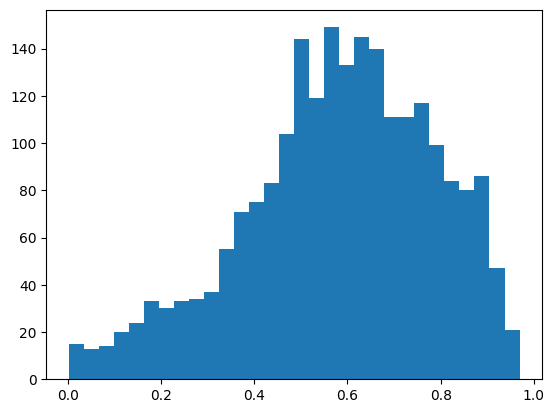

In [18]:
plt.hist(nses[nses>0], bins = 30)
plt.show()

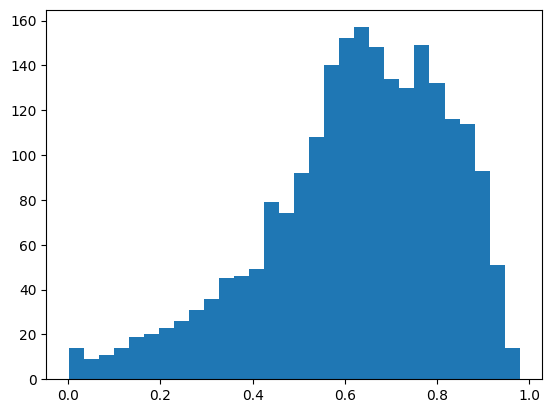

In [19]:
plt.hist(kges[kges>0], bins = 30)
plt.show()

In [20]:
kges.mean(), nses.mean()

(0.5447895122641498, 0.4130420363194548)

In [21]:
y2.shape, preds2.shape

((2346, 4015), (2346, 4015))

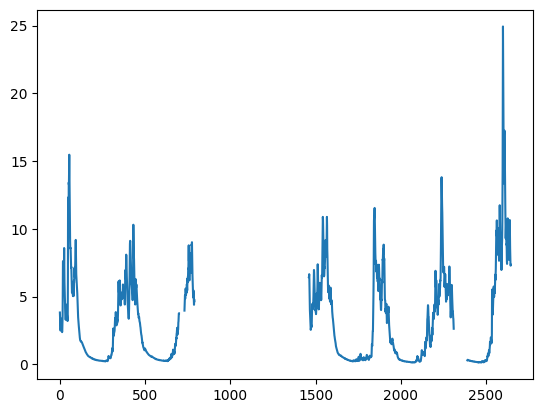

In [22]:
plt.plot(y2[0,:])

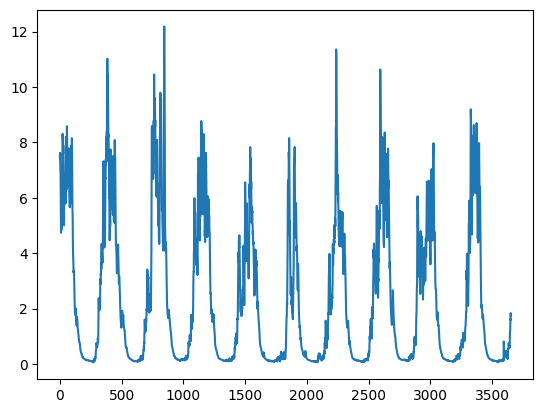

In [23]:
plt.plot(preds2[0,:])

In [24]:
np.median(kges)

0.6331142138750274

In [25]:
np.median(nses)

0.5830931812524796